In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit

from constants import DATA_DIR, RAW_DIR
from src.damit_connector import AsteroidDownloader
from src.model import Asteroid, Lightcurve

sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [2]:
ASTEROIDS_DF = pd.read_csv(DATA_DIR / "asteroids.csv", index_col=0)
ASTEROIDS_DF = ASTEROIDS_DF.dropna(subset=["number"])
ASTEROIDS_DF["number"] = ASTEROIDS_DF["number"].astype(int)
ASTEROIDS_DF

,number,name,designation,comment,created,modified
id,,,,,,
3414,1,Ceres,NaN,albedo effects,2021-11-18 10:13:38,2021-11-18 10:14:01
101,2,Pallas,NaN,NaN,NaN,2019-05-31 11:22:28
102,3,Juno,NaN,NaN,NaN,2010-04-15 15:54:09
3415,4,Vesta,NaN,albedo effects,2021-11-19 11:18:10,2021-11-19 11:27:06
103,5,Astraea,NaN,NaN,NaN,2010-04-15 15:54:09
...,...,...,...,...,...,...
7103,353971,NaN,NaN,NaN,2023-05-23 07:51:09,2023-05-23 07:51:09
7110,354510,NaN,NaN,NaN,2023-05-23 07:51:09,2023-05-23 07:51:09
7194,362935,NaN,NaN,NaN,2023-05-23 07:51:13,2023-05-23 07:51:13


In [3]:
downloader = AsteroidDownloader(ASTEROIDS_DF)

In [4]:
if False:
    downloader.query_asteroid("Pallas")

In [5]:
C_G_S = "\033[1;32m"
C_Y_S = "\033[1;33m"
C_E = "\033[0m"


In [6]:
PERIOD_FILE = "period.txt"

In [10]:
AVAILABLE_ASTEROIDS = {}
for directory in RAW_DIR.iterdir():
    if not directory.is_dir():
        continue

    asteroid_name = directory.name.split("_")[0]
    work_name = directory.name

    res = ASTEROIDS_DF.query(f"name == '{asteroid_name}'")
    if len(res) != 1:
        raise ValueError(f"Found multiple asteroids with name {asteroid_name} (work name: {work_name})")

    (asteroid_num,) = res["number"]

    if not (directory / PERIOD_FILE).exists():
        raise FileNotFoundError(f"Missing {PERIOD_FILE} for {work_name}")
    
    with open(directory / PERIOD_FILE, "r") as f:
        period = float(f.read().strip())
    
    AVAILABLE_ASTEROIDS[work_name] = {"id": asteroid_num, "name": asteroid_name, "period": period}

In [11]:
AVAILABLE_ASTEROIDS

{'Juno_1': {'id': 3, 'name': 'Juno', 'period': 7.209531},
 'Juno_2': {'id': 3, 'name': 'Juno', 'period': 7.20953},
 'Vesta': {'id': 4, 'name': 'Vesta', 'period': 5.342124},
 'Eros': {'id': 433, 'name': 'Eros', 'period': 5.27025528},
 'Pallas_1': {'id': 2, 'name': 'Pallas', 'period': 7.81323},
 'Pallas_2': {'id': 2, 'name': 'Pallas', 'period': 7.81322},
 'Pallas_3': {'id': 2, 'name': 'Pallas', 'period': 7.81322}}

In [12]:
asteroid_name = "Eros"
chosen_asteroid = AVAILABLE_ASTEROIDS[asteroid_name]
asteroid_id, known_period = chosen_asteroid["id"], chosen_asteroid["period"]

with open(RAW_DIR / asteroid_name / "lc.json", "r") as f:
    raw_data = json.load(f)

In [13]:
raw_data[0]

{'LightCurve': {'id': '14537',
  'asteroid_id': '1714',
  'scale': '0',
  'filter': None,
  'points': '2433915.385708  1.021246e+00    -1.49250950  -0.20313009  -0.25692782   -0.49091309  -0.15648988  -0.25691486\n2433915.401167  1.018429e+00    -1.49243437  -0.20332590  -0.25693732   -0.49085471  -0.15642099  -0.25692433\n2433915.407583  1.030696e+00    -1.49240319  -0.20340717  -0.25694127   -0.49083050  -0.15639240  -0.25692825\n2433915.423333  1.025016e+00    -1.49232660  -0.20360666  -0.25695094   -0.49077108  -0.15632220  -0.25693789\n2433915.434000  1.008163e+00    -1.49227472  -0.20374176  -0.25695749   -0.49073086  -0.15627466  -0.25694442\n2433915.443625  9.897614e-01    -1.49222789  -0.20386366  -0.25696339   -0.49069459  -0.15623177  -0.25695030\n2433915.453542  9.469576e-01    -1.49217962  -0.20398927  -0.25696948   -0.49065723  -0.15618757  -0.25695637\n2433915.458333  9.211503e-01    -1.49215630  -0.20404995  -0.25697241   -0.49063919  -0.15616622  -0.25695929\n2433915.4

In [14]:
asteroid = Asteroid.from_lightcurves(
    id=asteroid_id,
    name=asteroid_name,
    period=known_period,
    data=raw_data
)
asteroid

Asteroid(id=433, name=Eros, period=5.27025528, lightcurves=118)

In [15]:
asteroid.longest_lightcurve

Lightcurve(id=14587, created_at=2019-03-08 10:57:09 scale=0, points_count=192)

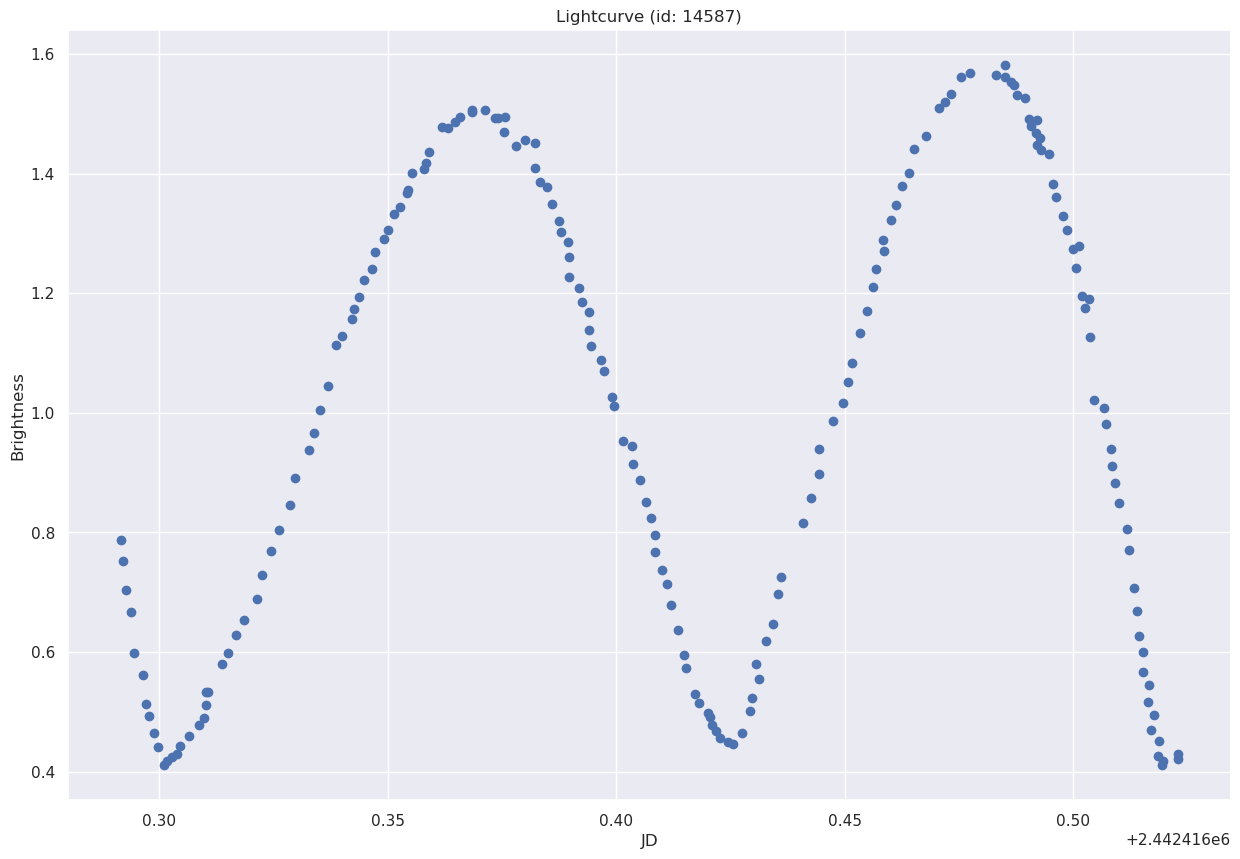

In [16]:
asteroid.longest_lightcurve.plot()

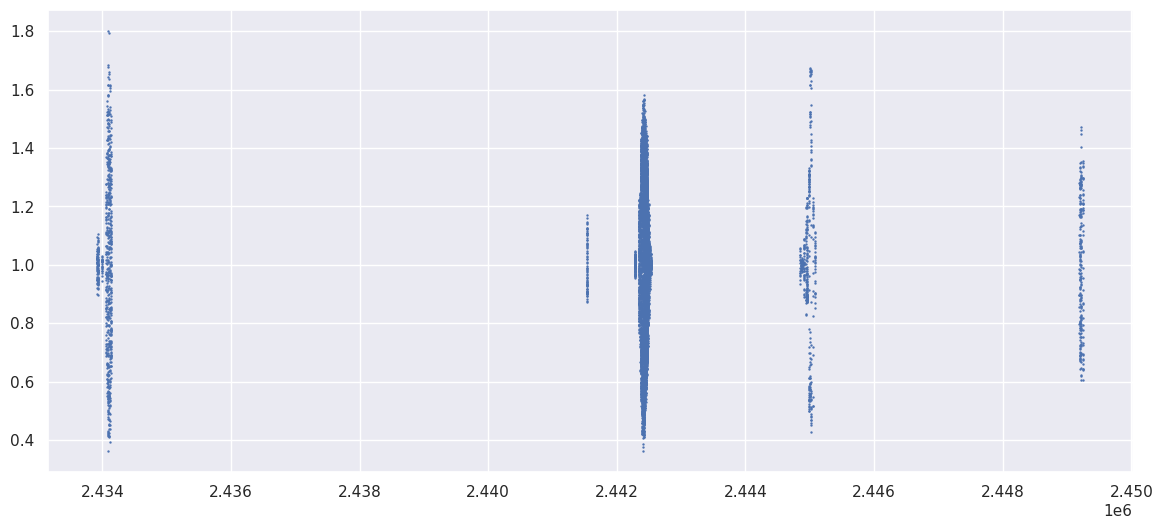

In [17]:
brightness = []
times = []
for lc in asteroid.lightcurves:
    for point in lc.points:
        brightness.append(point.brightness)
        times.append(point.JD)

plt.scatter(times, brightness, s=0.5)
plt.show()


In [18]:
MAX_DIFF_THRESHOLD = 45  # days
bins: list[list[Lightcurve]] = [[]]

curr_bin = 0
bin_start = None
for lc in asteroid.lightcurves:
    if bin_start is None:
        bin_start = lc.first_JD

    if lc.last_JD - bin_start > MAX_DIFF_THRESHOLD:
        curr_bin += 1
        bin_start = lc.first_JD
        bins.append([])

    bins[curr_bin].append(lc)

for ind, _bin in enumerate(bins):
    first_JD = _bin[0].first_JD
    last_JD = _bin[-1].last_JD
    print(f"{ind:2} - {C_Y_S}{len(_bin):2}{C_E} lcs from {first_JD:.2f} to {last_JD:.2f} {C_G_S}({last_JD - first_JD:5.2f} days){C_E}")

 0 -  4 lcs from 2433915.39 to 2433934.61 (19.22 days)
 1 -  1 lcs from 2433994.34 to 2433994.51 ( 0.17 days)
 2 - 11 lcs from 2434054.24 to 2434098.47 (44.23 days)
 3 - 12 lcs from 2434100.30 to 2434135.42 (35.12 days)
 4 -  1 lcs from 2441533.85 to 2441534.11 ( 0.26 days)
 5 -  2 lcs from 2442281.84 to 2442284.98 ( 3.14 days)
 6 - 11 lcs from 2442338.77 to 2442377.01 (38.24 days)
 7 - 17 lcs from 2442387.80 to 2442431.97 (44.16 days)
 8 - 23 lcs from 2442432.67 to 2442471.47 (38.81 days)
 9 -  8 lcs from 2442481.64 to 2442508.79 (27.15 days)
10 -  2 lcs from 2442535.65 to 2442536.70 ( 1.05 days)
11 -  3 lcs from 2444850.79 to 2444874.02 (23.23 days)
12 -  4 lcs from 2444908.74 to 2444941.83 (33.09 days)
13 -  4 lcs from 2444956.65 to 2445000.82 (44.17 days)
14 -  2 lcs from 2445019.62 to 2445052.80 (33.18 days)
15 -  3 lcs from 2445081.64 to 2445083.72 ( 2.07 days)
16 -  9 lcs from 2449191.43 to 2449222.43 (31.01 days)
17 -  1 lcs from 2449252.21 to 2449252.33 ( 0.12 days)


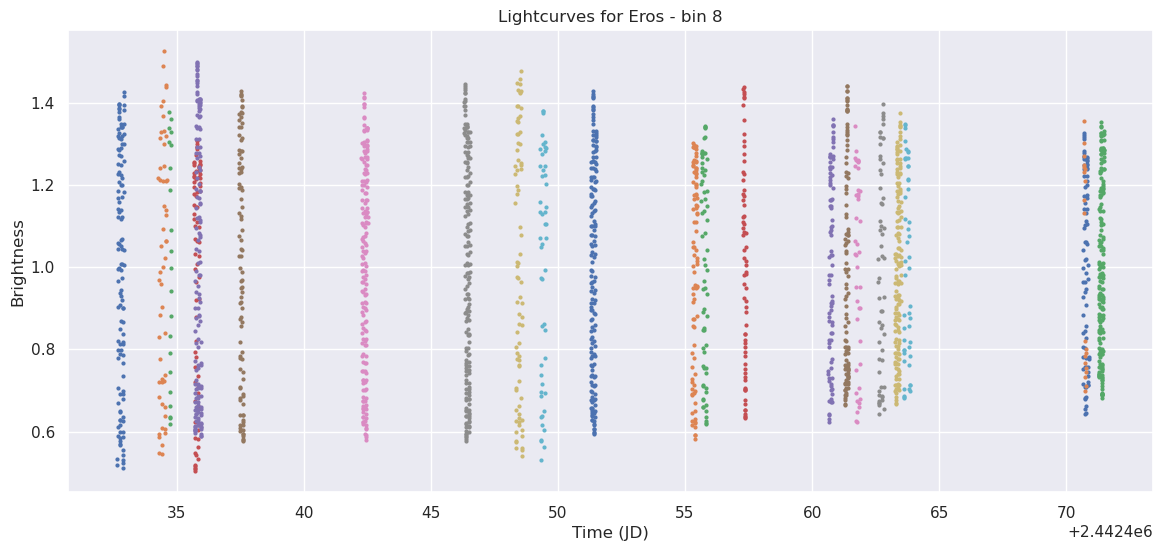

In [20]:
SELECTED_BIN = np.argmax([len(_bin) for _bin in bins])
selected_bin = bins[SELECTED_BIN]
for ind, lc in enumerate(selected_bin):
    times = []
    brightness = []
    for points in lc.points:
        times.append(points.JD)
        brightness.append(points.brightness)

    plt.scatter(times, brightness, s=4)

plt.title(f"Lightcurves for {asteroid_name} - bin {SELECTED_BIN}")
plt.xlabel("Time (JD)")
plt.ylabel("Brightness")
plt.show()

Best frequency: 9.223480079112687
Rotational period: 2.602054733586939h


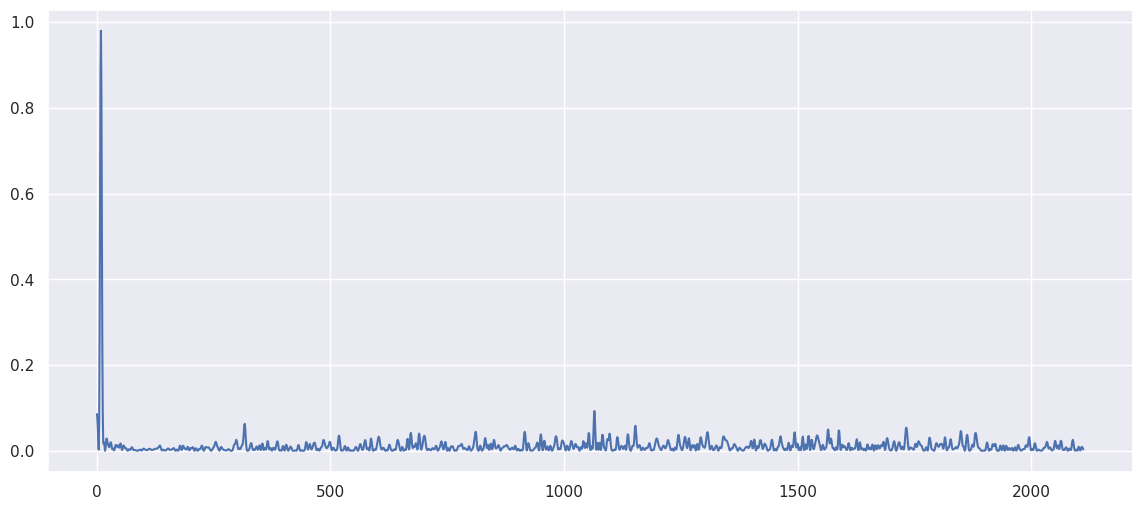

In [21]:
frequency, power = LombScargle(times, brightness).autopower()
_ = plt.plot(frequency, power)

best_frequency = frequency[np.argmax(power)]
best_period = 24 / best_frequency

print(f"Best frequency: {best_frequency}")
print(f"Rotational period: {best_period}h")

In [22]:
def get_phase(time: float, ref_time: float, period: float) -> float:
    return (time - ref_time) * 24 % period / period
    

In [23]:
known_period

5.27025528

In [24]:
known_period / 2

2.63512764

In [25]:
best_period * 2

5.204109467173878

In [26]:
def plot_phased_lightcurves(selected_bin: list[Lightcurve], period: float):
    ref_JD = None
    for lc in selected_bin:
        if ref_JD is None:
            ref_JD = lc.first_JD

        phases = []
        brightness = []
        for point in lc.points:

            phase = get_phase(point.JD, ref_JD, period)

            phases.append(phase)
            brightness.append(point.brightness)

        plt.scatter(phases, brightness, s=8, label=f"Lightcurve {lc.id}")


    plt.title(f"Phased lightcurves for {asteroid_name} - bin {SELECTED_BIN}")
    plt.xlabel("Phase")
    plt.ylabel("Brightness")
    plt.show()

In [27]:
if False:
    # Grid search for the best period
    for inc in np.linspace(-0.1, 0.1):
        ref_JD = None
        period = best_period * 2 + inc
        print(f"Trying period: {period:.6f}h")
        for ind, lc in enumerate(selected_bin):
            if ref_JD is None:
                ref_JD = lc.first_JD

            phases = []
            brightness = []
            for point in lc.points:
                phase = get_phase(point.JD, ref_JD, period)

                phases.append(phase)
                brightness.append(point.brightness)

            plt.scatter(phases, brightness, s=8, label=f"Lightcurve {lc.id}")


        plt.title(f"Phased lightcurves for {asteroid_name} - bin {SELECTED_BIN}")
        plt.xlabel("Phase")
        plt.ylabel("Brightness")
        # plt.legend()
        plt.show()

In [28]:
best_period * 2

5.204109467173878

In [29]:
known_period

5.27025528

In [30]:
def sinusoidal_model(phase, amplitude, phase_shift, offset):
    return amplitude * np.sin(2 * np.pi * phase + phase_shift) + offset


def harmonic_model(phase, a0, a1, b1, a2, b2, offset):
    # a1, b1 are the coefficients for the fundamental harmonic (1st harmonic)
    # a2, b2 are the coefficients for the 2nd harmonic
    return (
        a0
        + a1 * np.cos(2 * np.pi * phase)
        + b1 * np.sin(2 * np.pi * phase)
        + a2 * np.cos(4 * np.pi * phase)
        + b2 * np.sin(4 * np.pi * phase)
        + offset
    )


def get_rrs_values(period_range):
    rss_values = []
    for curr_period in period_range:
        # print(f"Trying period: {curr_period:.6f}h")

        phases = []
        brightness = []
        ref_JD = None
        for ind, lc in enumerate(selected_bin):
            if ref_JD is None:
                ref_JD = lc.first_JD

            for point in lc.points:
                phase = get_phase(point.JD, ref_JD, curr_period)

                phases.append(phase)
                brightness.append(point.brightness)

        sorted_indices = np.argsort(phases)
        phases = np.array(phases)[sorted_indices]
        brightness = np.array(brightness)[sorted_indices]

        # Initial guesses for the coefficients: a0, a1, b1, a2, b2, offset
        # a0 is the coefficient for the 0th harmonic (average level), usually close to the mean of the data
        # a1, b1 are for the first harmonic and so on
        # fmt: off
        initial_guesses = [
            np.mean(brightness),        # a0
            np.std(brightness),         # a1
            0,                          # b1
            np.std(brightness) / 2,     # a2
            0,                          # b2
            np.mean(brightness),        # offset
        ]
        # fmt: on

        popt, _ = curve_fit(harmonic_model, phases, brightness, p0=initial_guesses)
        predicted_brightness = harmonic_model(phases, *popt)

        # plt.scatter(phases, brightness, s=8, label=f"Lightcurve {lc.id}")
        # plt.plot(phases, predicted_brightness, label="Fit", color="orange")
        # plt.title(f"Phased lightcurves for {asteroid_name} - bin {SELECTED_BIN}")
        # plt.xlabel("Phase")
        # plt.ylabel("Brightness")
        # plt.legend()
        # plt.show()

        residuals = brightness - predicted_brightness
        rss = np.sum(residuals**2)

        rss_values.append(rss)

    return rss_values

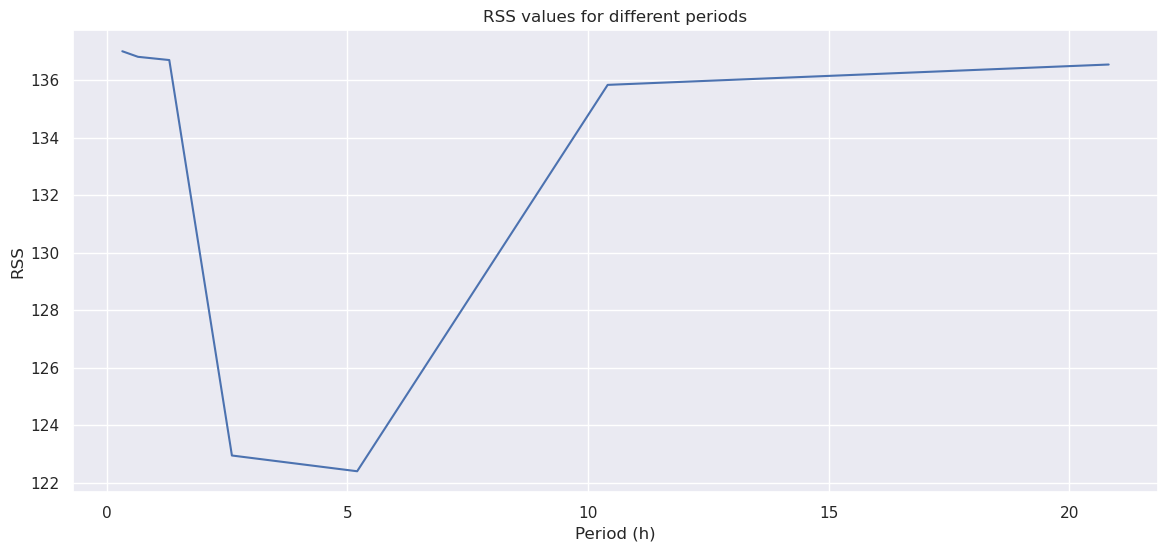

Selected periods: [2.602054733586939, 5.204109467173878]

Best RSS value: 10.904199 found for period: 5.269766h
Compared to the known period: 5.270255h (diff: 0.000489h)


In [31]:
period_range = [best_period / 8, best_period / 4, best_period / 2, best_period, best_period * 2, best_period * 4, best_period * 8]
rss_values = get_rrs_values(period_range)

plt.plot(period_range, rss_values)
plt.title("RSS values for different periods")
plt.xlabel("Period (h)")
plt.ylabel("RSS")
plt.show()

# Select the period with the lowest RSS as well as ones close to the lowest RSS
min_rss = np.min(rss_values)
selected_periods = []
for period, rss in zip(period_range, rss_values):
    if rss < min_rss + 1:
        selected_periods.append(period)

print(f"Selected periods: {selected_periods}\n")

promising_periods = []
final_values = []
for period in selected_periods:
    period_range = np.linspace(period - 0.1, period + 0.1, 100)    
    rss_values = get_rrs_values(period_range)

    lowest_ind = np.argmin(rss_values)
    final_values.append(period_range[lowest_ind])
    promising_periods.append(period_range[lowest_ind])


best_rss_ind = np.argmin(rss_values)

best_period = period_range[best_rss_ind]
best_rss = rss_values[best_rss_ind]

print(f"Best RSS value: {best_rss:.6f} found for period: {best_period:.6f}h")
print(f"Compared to the known period: {known_period:.6f}h (diff: {C_Y_S}{known_period - best_period:.6f}h{C_E})")

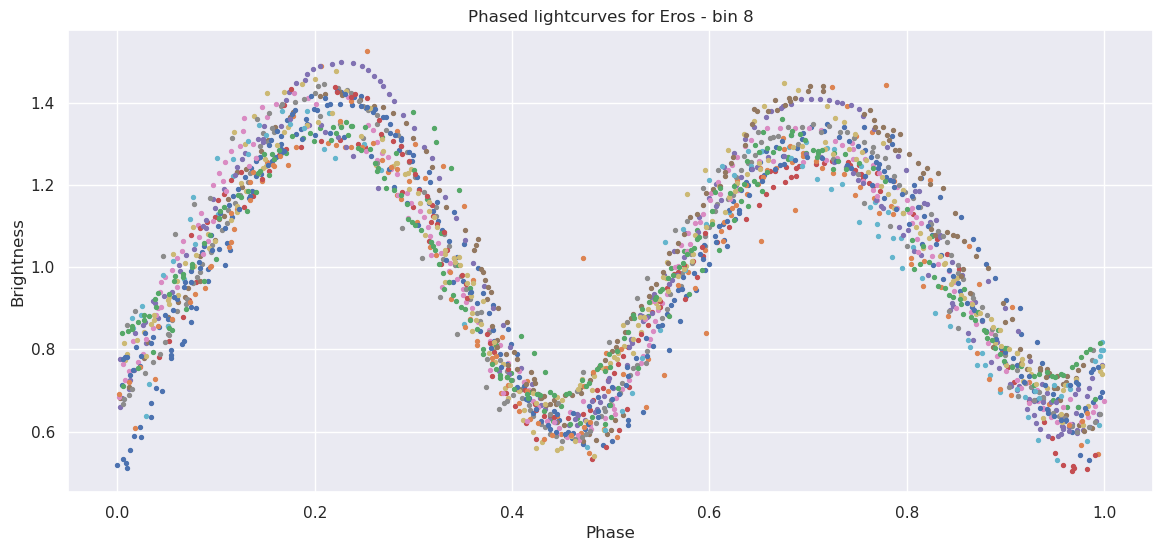

In [32]:
plot_phased_lightcurves(selected_bin, best_period)